In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression


In [2]:

# ID du Google Sheet et GID de l'onglet
sheet_id = "1PdnadzZswADLqGBrI53a_8IsegivCMSz1pCZOh384-Y"
gid = "1517184233"

# Construction du lien CSV public de Google Sheets
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

# Lecture du CSV directement dans un DataFrame
df = pd.read_csv(url)

# Si ton tableau commence à la colonne D (donc avec des colonnes vides avant),
# on peut supprimer les colonnes vides automatiquement :
df = df.dropna(axis=1, how="all")
df = df.replace("-", np.nan)
df = df.dropna(subset=['Team Gap Early', 'Est. Win'])

**ATTENTION** : cette formule fait une prédiction entre 20 ET 80 pour le **TEAM GAP EARLY**, pas une prédiction sur la WIN. (on peut le changer)
- Actuellement cette formule est pour la ligne 9 puis il faut la faire glisser sur les autres cases après


In [11]:
features = ["Team Gap Early", "R", "Perf relative", "Perf intrinsèque"]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[features])

window = 7
X, y = [], []

for i in range(len(data_scaled) - window):
    X.append(data_scaled[i:i+window])
    y.append(data_scaled[i + window, 0])  # prédire la prochaine valeur de Team Gap Early

X = np.array(X)
y = np.array(y)

# --- Dataset PyTorch ---
class LoLDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = LoLDataset(X, y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# --- Définition du modèle LSTM ---
class LoLModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # On prend la dernière sortie temporelle
        return out.squeeze(1)

model = LoLModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Entraînement ---
for epoch in range(200):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader):.4f}")

# --- Prédiction sur la dernière séquence ---
model.eval()
last_seq = torch.tensor(X[-1].reshape(1, window, 4), dtype=torch.float32)
pred_scaled = model(last_seq).item()

# Reconvertir à l’échelle originale
pred_real = scaler.inverse_transform(
    np.hstack([[[pred_scaled]], np.zeros((1, 3))])
)[0, 0]

model.eval()
with torch.no_grad():
    y_pred_lstm = model(torch.tensor(X, dtype=torch.float32)).numpy().flatten()

X_flat = X.reshape(X.shape[0], -1)

lin_model = LinearRegression()
lin_model.fit(X_flat, y_pred_lstm)


Epoch 0, Loss: 0.7419
Epoch 50, Loss: 0.1625
Epoch 100, Loss: 0.0585
Epoch 150, Loss: 0.0048


LinearRegression()

In [12]:
def generate_excel_formula_lstm(row, coefs, intercept, window=7, start_row=2):

    features_letters = ["F", "G", "H", "I"] 
    
    inner = f"({intercept:.4f}".replace(".", ",")
    
    # Chaque feature a des coefficients pour 7 décalages
    for feat_idx, col_letter in enumerate(features_letters):
        inner += f"+("  # ouvrir bloc de la feature
        
        for lag_idx in range(window):
            coef_idx = feat_idx * window + lag_idx
            coef = coefs[coef_idx]
            lag_row = row - (window - lag_idx)
            inner += f"{coef:.4f}*{col_letter}{lag_row}+"
        
        inner = inner.rstrip("+") + ")"  # fermeture bloc de la feature
    
    inner += ")"  # fermeture globale
    
    # --- Mapping final sur [20, 80] ---
    formula = f"=20+(({inner})+3)*10"
    formula = formula.replace(".", ",")
    
    return formula

row_number = 9  
excel_formula_row9 = generate_excel_formula_lstm(
    row=row_number,
    coefs=lin_model.coef_,
    intercept=lin_model.intercept_,
    window=7
)

print(excel_formula_row9)


=20+(((0,3578+(-0,1156*F2+-0,1823*F3+0,0820*F4+-0,1801*F5+-0,2174*F6+-0,0584*F7+0,0449*F8)+(-0,0972*G2+-0,2808*G3+0,0628*G4+0,0448*G5+-0,0714*G6+-0,2496*G7+-0,2632*G8)+(-0,2597*H2+-0,1705*H3+-0,0061*H4+-0,1816*H5+-0,2229*H6+-0,0971*H7+-0,1872*H8)+(-0,1384*I2+-0,0029*I3+-0,0187*I4+-0,0979*I5+0,1422*I6+-0,1841*I7+-0,1909*I8)))+3)*10


### Bonus matrice de corrélation

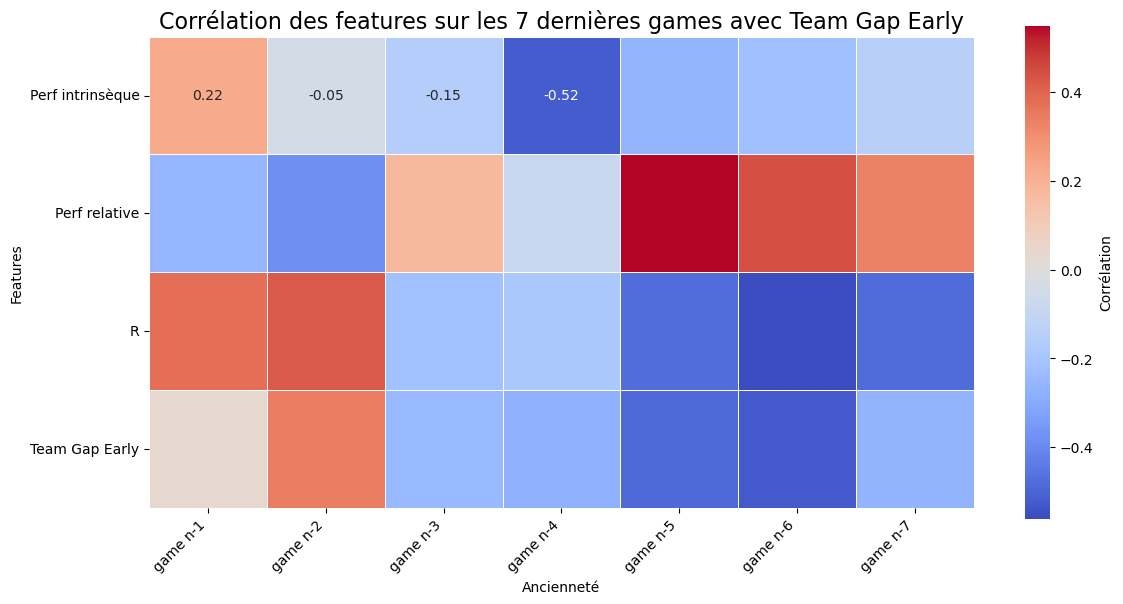

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features = ['R', 'Perf relative', 'Perf intrinsèque', 'Team Gap Early']
target = 'Team Gap Early'
max_lag = 7

df_lagged = df.copy()

# Créer les colonnes lag
for feat in features:
    for lag in range(1, max_lag + 1):
        df_lagged[f'{feat}_lag{lag}'] = df_lagged[feat].shift(lag)

# Supprimer les lignes avec target NaN
df_corr = df_lagged.dropna(subset=[target])

# Calcul des corrélations
corr_dict = {}
for feat in features:
    for lag in range(1, max_lag + 1):
        corr_dict[f'{feat}_lag{lag}'] = df_corr[target].corr(df_corr[f'{feat}_lag{lag}'])

corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['Correlation'])
corr_df['Feature'] = [name.split('_lag')[0] for name in corr_df.index]
corr_df['Lag'] = [int(name.split('_lag')[1]) for name in corr_df.index]

# Pivot pour heatmap
heatmap_data = corr_df.pivot(index='Feature', columns='Lag', values='Correlation')

# Heatmap avec labels
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Corrélation'},
    linewidths=0.5,
    square=True
)

# Forcer les labels pour toutes les cases
ax.set_xticklabels([f"game n-{i}" for i in heatmap_data.columns], rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=10)

plt.title('Corrélation des features sur les 7 dernières games avec Team Gap Early', fontsize=16)
plt.xlabel('Ancienneté')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
